In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, set_seed
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
set_seed(1)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
df = pd.read_csv("features.csv", na_values = "None")
df.head()

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,inline,1,0,1,1,ie,1.0,0.0,0.0,7.0,1,2.0,0.0,0,Re: [ILUG] Architecture crossover trouble w RH...
1,1,text/plain,NaN,2,0,8,0,com,1.0,0.0,1.0,3.0,0,1.0,1.0,1,Cash in on your home equity7bit Mortgage Lende...
2,1,text/plain,NaN,4,0,7,1,com,1.0,1.0,0.0,10.0,0,3.0,1.0,1,Are Your Mortgage Rates The Best They Can Be.....
3,1,text/html,NaN,1,1,0,0,cn,0.0,0.0,1.0,3.0,0,3.0,1.0,1,Online Approval for $5000 Now7bit\nFree Card S...
4,1,text/plain,inline,2,0,0,1,ie,1.0,0.0,0.0,7.0,1,3.0,0.0,0,Re: [ILUG] expanding a string multiple timesil...


In [4]:
df1 = df.map(lambda x: x.lower().strip() if isinstance(x, str) else x)

cleaning feature $content\_type$

In [ ]:
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("text/html")[0] + "text/html" if isinstance(x, str) and "text/html" in x else x)
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("text/plain")[0] + "text/plain" if isinstance(x, str) and "text/plain" in x else x)
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("application")[0] + "application" if isinstance(x, str) and "application" in x else x)

cleaning feature $content\_disp$

In [ ]:
df1["content_disp"] = df1["content_disp"].apply(lambda x: x.split(";")[0] if isinstance(x, str) and ";" in x else x)
df1["content_disp"] = df1["content_disp"].apply(lambda x: x.split("inline")[0] + "inline" if isinstance(x, str) and "inline" in x else x)

change categorical data into integer

In [ ]:
int_col = ["has_subject", "num_html", "has_attachement", "num_exc_mark", "has_list_id", "check_spf", "check_dkim", "from_returnpath_same", "num_received", "is_replied", "time_period", "is_weekday"]
df1[int_col] = df1[int_col].apply(pd.to_numeric, errors = "coerce").astype("Int64")

remove values in feature $domain$ appear less than 15 times

In [ ]:
threshold = 15
value_counts = df1["domain"].value_counts()
df1["domain"] = df1["domain"].apply(lambda x: x if isinstance(x, str) and value_counts[x] >= threshold else "Other")

The cleaned dataset

In [9]:
df1.head()

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,inline,1,0,1,1,ie,1,0,0,7,1,2,0,0,re: [ilug] architecture crossover trouble w rh...
1,1,text/plain,NaN,2,0,8,0,com,1,0,1,3,0,1,1,1,cash in on your home equity7bit mortgage lende...
2,1,text/plain,NaN,4,0,7,1,com,1,1,0,10,0,3,1,1,are your mortgage rates the best they can be.....
3,1,text/html,NaN,1,1,0,0,cn,0,0,1,3,0,3,1,1,online approval for $5000 now7bit\nfree card s...
4,1,text/plain,inline,2,0,0,1,ie,1,0,0,7,1,3,0,0,re: [ilug] expanding a string multiple timesil...


input content for BERT model

In [10]:
process_content_list = df1.iloc[:, -1].tolist()

This is the label

In [11]:
labels = df1.iloc[:, -2].tolist()

dataset for machine learning-based classifier

In [12]:
df_train = df1.iloc[:, :-2] 
df_train

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday
0,1,text/plain,inline,1,0,1,1,ie,1,0,0,7,1,2,0
1,1,text/plain,NaN,2,0,8,0,com,1,0,1,3,0,1,1
2,1,text/plain,NaN,4,0,7,1,com,1,1,0,10,0,3,1
3,1,text/html,NaN,1,1,0,0,cn,0,0,1,3,0,3,1
4,1,text/plain,inline,2,0,0,1,ie,1,0,0,7,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,1,text/plain,NaN,1,0,0,1,ie,1,0,0,8,1,2,1
5792,1,text/plain,NaN,0,0,0,1,com,1,1,0,7,1,2,1
5793,1,text/html,NaN,1,1,2,0,Other,<NA>,<NA>,<NA>,7,0,2,0
5794,1,text/plain,NaN,3,0,0,1,net,0,0,0,7,1,2,1


apply one hot encoding to categorical data

In [ ]:
one_hot_col = ["content_type", "content_disp", "domain", "time_period"]
encoder = OneHotEncoder(drop = "first", sparse_output = False, handle_unknown = "ignore") 
encoded_cats = encoder.fit_transform(df_train[one_hot_col])
encoded_df = pd.DataFrame(encoded_cats, columns = encoder.get_feature_names_out(one_hot_col)).astype(int)
encoded_df[df_train[one_hot_col].isna()] = pd.NA
df_train1 = df_train.drop(columns = one_hot_col).join(encoded_df)
df_train1

,has_subject,num_html,has_attachement,num_exc_mark,has_list_id,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,...,domain_dk,domain_ie,domain_net,domain_org,domain_ru,domain_uk,domain_us,time_period_2.0,time_period_3.0,time_period_nan
0,1,1,0,1,1,1,0,0,7,1,...,0,1,0,0,0,0,0,1,0,0
1,1,2,0,8,0,1,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,7,1,1,1,0,10,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2,0,0,1,1,0,0,7,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,1,1,0,0,1,1,0,0,8,1,...,0,1,0,0,0,0,0,1,0,0
5792,1,0,0,0,1,1,1,0,7,1,...,0,0,0,0,0,0,0,1,0,0
5793,1,1,1,2,0,<NA>,<NA>,<NA>,7,0,...,0,0,0,0,0,0,0,1,0,0
5794,1,3,0,0,1,0,0,0,7,1,...,0,0,1,0,0,0,0,1,0,0


replace na with median values

In [21]:
df_train1 = df_train1.fillna(df_train1.median())
df_train1

,has_subject,num_html,has_attachement,num_exc_mark,has_list_id,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,...,domain_dk,domain_ie,domain_net,domain_org,domain_ru,domain_uk,domain_us,time_period_2.0,time_period_3.0,time_period_nan
0,1,1,0,1,1,1,0,0,7,1,...,0,1,0,0,0,0,0,1,0,0
1,1,2,0,8,0,1,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,7,1,1,1,0,10,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2,0,0,1,1,0,0,7,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,1,1,0,0,1,1,0,0,8,1,...,0,1,0,0,0,0,0,1,0,0
5792,1,0,0,0,1,1,1,0,7,1,...,0,0,0,0,0,0,0,1,0,0
5793,1,1,1,2,0,1,0,0,7,0,...,0,0,0,0,0,0,0,1,0,0
5794,1,3,0,0,1,0,0,0,7,1,...,0,0,1,0,0,0,0,1,0,0


split the dataset into 80% train, 10% validation, and 10% test

In [66]:
X_train, X_temp, y_train, y_temp = train_test_split(df_train1, labels, test_size = 0.2, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 1)

apply logistic regression on metadata features and output its validation performances

In [23]:
model = LogisticRegression(max_iter=500, random_state=1)
model.fit(X_train, y_train)

X_pred = model.predict(X_train)
X_pred_prob = model.predict_proba(X_train)[:, 1]

y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.9625    0.9872    0.9747       390
           1     0.9722    0.9211    0.9459       190

    accuracy                         0.9655       580
   macro avg     0.9674    0.9541    0.9603       580
weighted avg     0.9657    0.9655    0.9653       580



its training accuracy

In [24]:
accuracy_score(y_train, X_pred)

0.9663503019844694

apply XGBoost on metadata features and output its validation performances

In [27]:
from xgboost import XGBClassifier

model_xbg = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model_xbg.fit(X_train, y_train)

X_pred = model_xbg.predict(X_train)
X_pred_prob = model_xbg.predict_proba(X_train)[:, 1]

y_pred = model_xbg.predict(X_val)
y_pred_prob = model_xbg.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.9674    0.9897    0.9785       390
           1     0.9779    0.9316    0.9542       190

    accuracy                         0.9707       580
   macro avg     0.9727    0.9607    0.9663       580
weighted avg     0.9709    0.9707    0.9705       580



/home/linda/workspace/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:19:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


its training accuracy

In [28]:
accuracy_score(y_train, X_pred)

0.9967644521138913

apply SVM on metadata features and output its validation performances

In [25]:
from sklearn.svm import SVC

model_svm = SVC(probability=True)
model_svm.fit(X_train, y_train)

X_pred = model_svm.predict(X_train)
X_pred_prob = model_svm.predict_proba(X_train)[:, 1]

y_pred = model_svm.predict(X_val)
y_pred_prob = model_svm.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.96
              precision    recall  f1-score   support

           0     0.9578    0.9897    0.9735       390
           1     0.9774    0.9105    0.9428       190

    accuracy                         0.9638       580
   macro avg     0.9676    0.9501    0.9581       580
weighted avg     0.9642    0.9638    0.9634       580



its training accuracy

In [26]:
accuracy_score(y_train, X_pred)

0.9657031924072477

apply random forest on metadata features and output its validation performances

In [29]:
from sklearn.ensemble import RandomForestClassifier
def rf(X_train, y_train, X_val, y_val, n_est, min_s, min_s_l=1):
    model_rf = RandomForestClassifier(random_state=1, n_estimators = n_est, min_samples_split=min_s, min_samples_leaf=min_s_l)
    model_rf.fit(X_train, y_train)

    X_pred = model_rf.predict(X_train)
    X_pred_prob = model_rf.predict_proba(X_train)[:, 1]

    y_pred = model_rf.predict(X_val)
    y_pred_prob = model_rf.predict_proba(X_val)[:, 1]

    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(classification_report(y_val, y_pred, digits=4))

    return X_pred, X_pred_prob, y_pred, y_pred_prob

In [30]:
X_pred, X_pred_prob, y_pred, y_pred_prob = rf(X_train, y_train, X_val, y_val, 100, 2)

Accuracy: 0.98
              precision    recall  f1-score   support

           0     0.9748    0.9923    0.9835       390
           1     0.9836    0.9474    0.9651       190

    accuracy                         0.9776       580
   macro avg     0.9792    0.9698    0.9743       580
weighted avg     0.9777    0.9776    0.9775       580



its training accuracy

In [31]:
accuracy_score(y_train, X_pred)

0.9978429680759275

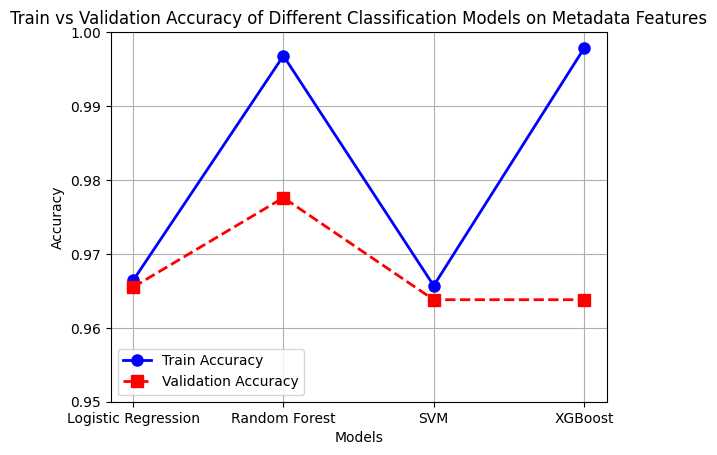

In [ ]:
model_name = ["Logistic Regression", "Random Forest", "SVM", "XGBoost"]
val_accuracy = [0.9655, 0.9776, 0.9638, 0.9638]
train_accuracy = [0.9664, 0.9968, 0.9657, 0.9978]
plt.plot(model_name, train_accuracy, marker="o", linestyle="-", color="blue", linewidth=2, markersize=8, label="Train Accuracy")
plt.plot(model_name, val_accuracy, marker="s", linestyle="--", color="red", linewidth=2, markersize=8, label="Validation Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy of Different Classification Models on Metadata Features")
plt.ylim(0.95, 1.0)  
plt.legend()
plt.grid(True)
plt.show()

get the test set prediction of random forest

In [77]:
X_pred, X_pred_prob, y_pred_test, y_pred_prob_test = rf(X_train, y_train, X_test, y_test, 100, 2)

Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.9816    0.9790    0.9803       381
           1     0.9600    0.9648    0.9624       199

    accuracy                         0.9741       580
   macro avg     0.9708    0.9719    0.9713       580
weighted avg     0.9742    0.9741    0.9742       580



processing the actual email content

In [ ]:
def text_preprocessing(email_content):

    email_content = email_content.replace("\n", " ").replace("\r", " ")
    email_content = re.sub(r"<[^>]+>", " ", email_content)
    email_content = re.sub(r"https?://\S+|www\.\S+", "[URL]", email_content)
    email_content = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "[EMAIL]", email_content)
    email_content = re.sub(r"[^a-zA-Z0-9.,!?"\s]", " ", email_content)
    email_content = re.sub(r"\s+", " ", email_content).strip()

    return email_content

In [ ]:
preprocessed_content = [text_preprocessing(i) if isinstance(i, str) else "None" for i in process_content_list]

create tokenizer on it

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", timeout = 30)
tokenized_inputs = tokenizer(preprocessed_content, truncation = True, padding = True, max_length = 512, return_tensors = "pt")

split it in 80% training, 10% validation, and 10% test

In [ ]:
attention_mask = tokenized_inputs["attention_mask"]
labels_tensor = torch.tensor(labels)
X_train_bert, X_temp_bert, train_mask_bert, temp_mask_bert, y_train_bert, y_temp_bert = train_test_split(tokenized_inputs["input_ids"], attention_mask, labels_tensor, test_size = 0.2, random_state = 1)
X_val_bert, X_test_bert, val_mask_bert, test_mask_bert, y_val_bert, y_test_bert = train_test_split(X_temp_bert, temp_mask_bert, y_temp_bert, test_size = 0.5, random_state = 1)

create data loader and download the pre-train BERT model

In [ ]:
def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)

train_dataset = TensorDataset(X_train_bert, train_mask_bert, y_train_bert)
val_dataset = TensorDataset(X_val_bert, val_mask_bert, y_val_bert)
test_dataset = TensorDataset(X_test_bert, test_mask_bert, y_test_bert)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)

model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

fine-tuning BERT model on email content

In [38]:
def bert_training(model_bert, lr_value, num_epochs, train_loader, device):

    optimizer = optim.AdamW(model_bert.parameters(), lr = lr_value, eps = 1e-8)
    loss_fn = nn.CrossEntropyLoss()

    epochs = num_epochs
    for epoch in range(epochs):
        model_bert.train()
        total_loss = 0
        correct = 0
        total = 0

        train_prob_list = []
        train_predictions = []
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model_bert(input_ids = b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits
            train_probs = F.softmax(logits, dim = 1)
            train_prob_list.extend(train_probs[:, 1].cpu().tolist())

            loss = loss_fn(outputs.logits, b_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim = 1)
            train_predictions.extend(predictions.cpu().tolist())
            correct += (predictions == b_labels).sum().item()
            total += b_labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        print(f'Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2%}')
    
    return train_prob_list, train_predictions

evaluate the BERT model

In [39]:
def bert_evaluation(model_bert, val_loader1, device):
    model_bert.eval()
    correct = 0
    total = 0

    val_predictions = []
    val_prob_list = []
    with torch.no_grad():
        for batch in val_loader1:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]

            outputs = model_bert(input_ids = b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits
            val_probs = F.softmax(logits, dim = 1)
            val_prob_list.extend(val_probs[:, 1].cpu().tolist())
            val_preds = torch.argmax(outputs.logits, dim = 1)
            val_predictions.extend(val_preds.cpu().tolist())
            correct += (val_preds == b_labels).sum().item()
            total += b_labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%}")

    return val_prob_list, val_predictions

The training accuracy

In [40]:
train_prob_list, train_predictions = bert_training(model_bert, 5e-5, 3, train_loader, device)

Epoch 1: Loss = 0.1041, Accuracy = 96.64%
Epoch 2: Loss = 0.0123, Accuracy = 99.65%
Epoch 3: Loss = 0.0106, Accuracy = 99.63%


The validation accuracy

In [41]:
val_prob_list, val_predictions = bert_evaluation(model_bert, val_loader, device)

Accuracy: 99.31%


The test accuracy

In [42]:
test_prob_list, test_predictions = bert_evaluation(model_bert, test_loader, device)

Accuracy: 99.66%


validation performance

In [43]:
report_bert = classification_report(y_val_bert, val_predictions, target_names = ["Ham", "Spam"], digits=4)
print(report_bert)

              precision    recall  f1-score   support

         Ham     0.9898    1.0000    0.9949       390
        Spam     1.0000    0.9789    0.9894       190

    accuracy                         0.9931       580
   macro avg     0.9949    0.9895    0.9921       580
weighted avg     0.9932    0.9931    0.9931       580



get combined training dataset and validation dataset containing predicted probability from random forest and BERT

In [47]:
comb_df = np.column_stack((train_prob_list, X_pred_prob))
comb_df_val = np.column_stack((val_prob_list, y_pred_prob))

apply random forest on the combined dataset to get the final classification and output the validation performance

In [67]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(comb_df, y_train)

train_pred = model_rf.predict(comb_df)
y_pred = model_rf.predict(comb_df_val)

print(f"Accuracy: {accuracy_score(y_val_bert, y_pred):.2f}")
print(classification_report(y_val_bert, y_pred, digits=4))


Accuracy: 0.99
              precision    recall  f1-score   support

           0     0.9898    0.9974    0.9936       390
           1     0.9947    0.9789    0.9867       190

    accuracy                         0.9914       580
   macro avg     0.9922    0.9882    0.9902       580
weighted avg     0.9914    0.9914    0.9914       580



its training accuracy

In [69]:
accuracy_score(y_train, train_pred)

1.0

apply linear regression on the combined dataset to get the final classification

In [49]:
model_lr = LinearRegression()
model_lr.fit(comb_df, y_train)

LinearRegression()

its training accuracy

In [70]:
train_pred_final = model_lr.predict(comb_df)
train_pred_final1 = [1 if i >= 0.5 else 0 for i in train_pred_final]
accuracy_score(y_train, train_pred_final1)

0.9987057808455565

In [50]:
val_pred_final = model_lr.predict(comb_df_val)

In [51]:
val_pred_final1 = [1 if i >= 0.5 else 0 for i in val_pred_final]

output the validation performance

In [63]:
report_final = classification_report(y_val_bert, val_pred_final1, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9924    1.0000    0.9962       390
        Spam     1.0000    0.9842    0.9920       190

    accuracy                         0.9948       580
   macro avg     0.9962    0.9921    0.9941       580
weighted avg     0.9949    0.9948    0.9948       580



apply logistic regression on the combined dataset to get the final classification and output the validation performance

In [53]:
meta_classifier = LogisticRegression()
meta_classifier.fit(comb_df, y_train)

LogisticRegression()

In [54]:
final_preds = meta_classifier.predict(comb_df_val)

In [55]:
report_final = classification_report(y_val_bert, final_preds, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9848    1.0000    0.9924       390
        Spam     1.0000    0.9684    0.9840       190

    accuracy                         0.9897       580
   macro avg     0.9924    0.9842    0.9882       580
weighted avg     0.9898    0.9897    0.9896       580



its training accuracy

In [71]:
final_train_preds = meta_classifier.predict(comb_df)
accuracy_score(y_train, final_train_preds)

0.9997842968075927

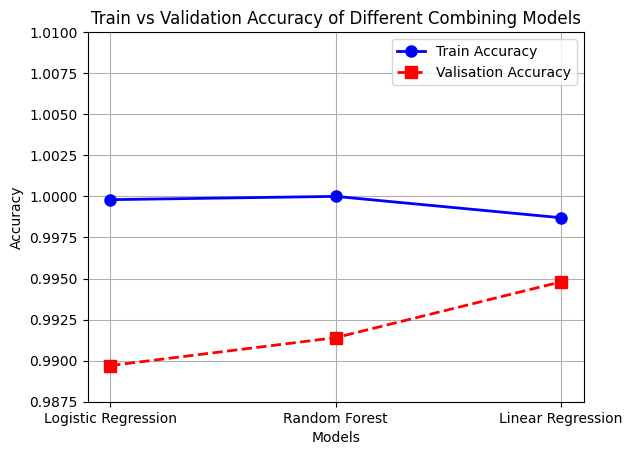

In [75]:
model_name_comb = ["Logistic Regression", "Random Forest", "Linear Regression"]
val_accuracy = [0.9897, 0.9914, 0.9948]
train_accuracy = [0.9998, 1, 0.9987]
plt.plot(model_name_comb, train_accuracy, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label="Train Accuracy")
plt.plot(model_name_comb, val_accuracy, marker='s', linestyle='--', color='red', linewidth=2, markersize=8, label="Valisation Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy of Different Combining Models")
plt.ylim(0.9875, 1.01)  
plt.legend()
plt.grid(True)
plt.show()

final hybrid model performance on the test set

In [78]:
comb_df_test = np.column_stack((test_prob_list, y_pred_prob_test))
test_pred_final = model_lr.predict(comb_df_test)
test_pred_final1 = [1 if i >= 0.5 else 0 for i in test_pred_final]
report_final_test = classification_report(y_test_bert, test_pred_final1, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9924    1.0000    0.9962       390
        Spam     1.0000    0.9842    0.9920       190

    accuracy                         0.9948       580
   macro avg     0.9962    0.9921    0.9941       580
weighted avg     0.9949    0.9948    0.9948       580

